In [377]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [379]:
# source: https://stackoverflow.com/questions/70825086/python-lowpass-filter-with-only-numpy
# source: https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial/notebook

def low_pass_filter(audio, *, sample_rate, band_limit = None):
    if band_limit is None:
        band_limit = sample_rate / 2
    cutoff_index = round(band_limit * audio.shape[0] / sample_rate)
    F = np.fft.rfft(audio)
    F[cutoff_index + 1:] = 0
    return np.fft.irfft(F, n = audio.size).real

def normalize_audio(audio):
    assert len(audio.shape) == 1
    s = np.max(np.abs(audio))
    if s == 0: s = 1
    return audio / s

def overlapping_chunks(audio, size: int):
    assert len(audio.shape) == 1
    res = []
    i = 0
    while i * size // 2 + size <= audio.shape[0]:
        res.append(audio[i * size // 2 : i * size // 2 + size])
        i += 1
    return np.array(res)

def hann_window(size: int):
    return np.cos(np.pi * (np.array(range(size)) - size / 2) / size)**2

def spectrogram(audio, *, fft_size: int, sample_rate: int):
    chunks = overlapping_chunks(normalize_audio(low_pass_filter(audio, sample_rate = sample_rate)), fft_size) * hann_window(fft_size)
    return np.array([np.fft.fft(chunk)[:fft_size // 2] for chunk in chunks])

def freq_to_mel(f: float) -> float:
    return 1127 * np.log(1 + f / 700)
def mel_to_freq(m: float) -> float:
    return 700 * (np.exp(m / 1127) - 1)

def dct(in_filters, out_filters):
    basis = np.empty((out_filters, in_filters))
    basis[0, :] = 1.0 / np.sqrt(in_filters)
    samples = np.arange(1, 2 * in_filters, 2) * np.pi / (2.0 * in_filters)
    for i in range(1, out_filters):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / in_filters)
    return basis

def mfcc_spectrogram(audio, *, fft_size: int, sample_rate: int, mel_filters: int, dct_filters: int):
    mel_freqs = mel_to_freq(np.linspace(freq_to_mel(0), freq_to_mel(sample_rate / 2), num = mel_filters + 2))
    filter_points = np.floor(fft_size / sample_rate * mel_freqs).astype(int)
    
    filters = np.zeros((len(filter_points) - 2, fft_size // 2))    
    for n in range(mel_filters):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    filters *= (2 / (mel_freqs[2 : mel_filters + 2] - mel_freqs[:mel_filters]))[:, np.newaxis]
    
    power = np.abs(spectrogram(audio, fft_size = fft_size, sample_rate = sample_rate))**2
    filtered = np.dot(filters, np.transpose(power))
    filtered[filtered > 0] = 10 * np.log10(filtered[filtered > 0])
    return np.dot(dct(mel_filters, dct_filters), filtered)

(65, 120)
-5.209903236306002 1.279473887490934


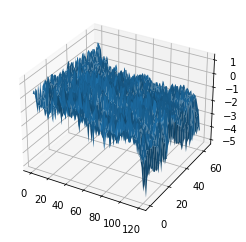

(65, 65)
0.0 1.0


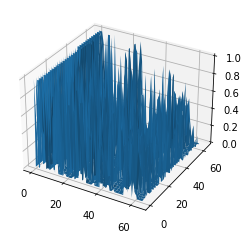

In [380]:
import dataloader
import random
audio, sample_rate = random.choice(random.choice(list(dataloader.get_dataset(1,1).items()))[1]), dataloader.UNIFORM_SAMPLE_RATE
fft_size = int(30 / 1000 * sample_rate)

spectrum = np.abs(spectrogram(audio, fft_size = fft_size, sample_rate = sample_rate))
spectrum_mel = mfcc_spectrogram(audio, fft_size = fft_size, sample_rate = sample_rate, mel_filters = 65, dct_filters = 65)

spectrum_mel = np.maximum(spectrum_mel, 0)
spectrum_mel = np.minimum(spectrum_mel, np.mean(spectrum_mel) + 1 * np.std(spectrum_mel))
spectrum_mel = spectrum_mel / np.max(spectrum_mel)

def plot3d(spectrum):
    assert len(spectrum.shape) == 2
    fig = plt.figure()
    p = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(spectrum.shape[1]), range(spectrum.shape[0]))
    p.plot_surface(x, y, spectrum)
    plt.show()
def show_info(trans):
    print(trans.shape)
    print(np.min(trans), np.max(trans))
    plot3d(trans)

show_info(np.log10(spectrum))
show_info(spectrum_mel.T)


# plt.figure(figsize = (5, 5))
# plt.plot(np.linspace(0, len(audio) / sample_rate, num = len(audio)), audio)
# plt.imshow(trans, aspect = 'auto', origin = 'lower')